In [1]:
import dns.query, dns.message, dns.rdatatype, dns.rdataclass
from dns.rdatatype import AAAA, A, DNSKEY, TXT
from dns.rdataclass import IN

In [2]:
ALGORITHMS = {
    5: "rsasha1", 8: "rsasha256", 10: "rsasha512",  # pdns also supports 7: "rsasha1-nsec3-sha1",
    13: "ecdsa256", 14: "ecdsa384",
    15: "ed25519", 16: "ed448",
    17: "falcon",
}
ALGORITHM_COLORS = {
    "rsasha1": "#ff0000", "rsasha256": "#dd0000", "rsasha512": "#bb0000",
    "ecdsa256": "#00ff00", "ecdsa384": "#00dd00",
    "ed25519": "#0000ff", "ed448": "#0000dd",
    "falcon": "#00ffff",
}

In [3]:
scenarios = {
    '2 A RRs with RRSIG': (A, lambda a: f'{a}.example.'),
    '1 AAAA RR with RRSIG': (AAAA, lambda a: f'{a}.example.'),
    '1 AAAA RR with RRSIG for Wildcard (NSEC)': (AAAA, lambda a: f'wildcard.{a}.example.'),
    '1 AAAA RR with RRSIG for Wildcard (NSEC3)': (AAAA, lambda a: f'wildcard.{a}3.example.'),
    '1 DNSKEY with RRSIG': (DNSKEY, lambda a: f'{a}.example.'),
    'NSEC Proof of NX': (TXT, lambda a: f'nx.{a}.example.'),
    'NSEC3 Proof of NX': (TXT, lambda a: f'nx.{a}3.example.'),
}

In [4]:
raw_data = []
for scenario, (rtype, name) in scenarios.items():
    for a in ALGORITHMS.values():
        qname = dns.name.from_text(name(a))
        r = dns.query.tcp(dns.message.make_query(qname, rtype, want_dnssec=True), where='127.0.0.1', port=5301)
        rwire = r.to_wire()
        raw_data.append({
            'scenario': scenario,
            'algorithm': a,
            'length': len(rwire),
            'qname_count': [rwire.count(qname.split(i)[1].to_wire()) for i in range(len(qname), 1, -1)],
            'qname': qname.to_text(),
        })

In [5]:
import pandas as pd

In [6]:
data = pd.DataFrame(raw_data)
data.sample(15)

,scenario,algorithm,length,qname_count,qname
33,1 DNSKEY with RRSIG,rsasha256,627,"[2, 2]",rsasha256.example.
37,1 DNSKEY with RRSIG,ed25519,203,"[2, 2]",ed25519.example.
26,1 AAAA RR with RRSIG for Wildcard (NSEC3),rsasha512,775,"[1, 3, 3]",wildcard.rsasha5123.example.
2,2 A RRs with RRSIG,rsasha512,383,"[2, 2]",rsasha512.example.
30,1 AAAA RR with RRSIG for Wildcard (NSEC3),ed448,480,"[1, 3, 3]",wildcard.ed4483.example.
5,2 A RRs with RRSIG,ed25519,187,"[2, 2]",ed25519.example.
42,NSEC Proof of NX,rsasha512,775,"[1, 4, 4]",nx.rsasha512.example.
47,NSEC Proof of NX,falcon,1570,"[1, 4, 4]",nx.falcon.example.
53,NSEC3 Proof of NX,ed25519,425,"[1, 3, 3]",nx.ed255193.example.
8,1 AAAA RR with RRSIG,rsasha1,375,"[2, 2]",rsasha1.example.


In [7]:
import seaborn as sns

sns.set(font_scale=2)
sns.set_style('whitegrid')

In [8]:
ALGORITHM_ORDER = list(ALGORITHM_COLORS.keys())
ALGORITHM_PALETTE = sns.color_palette([ALGORITHM_COLORS[a] for a in ALGORITHM_ORDER])

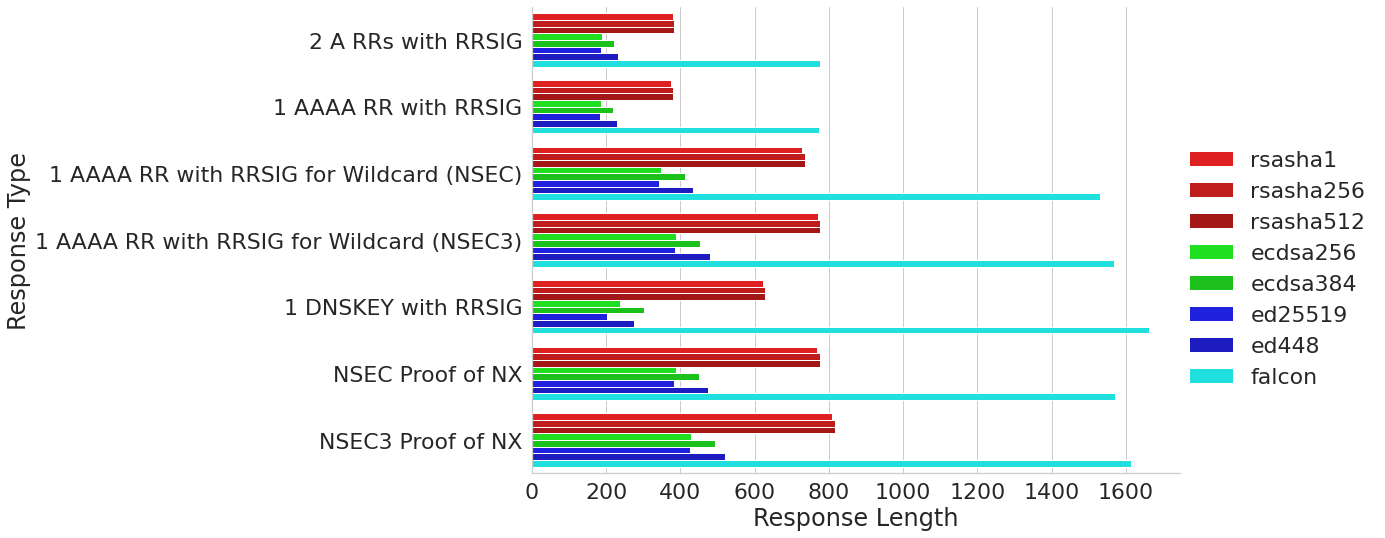

In [9]:
g = sns.catplot(
    data=data,
    y='scenario',
    hue='algorithm', hue_order=ALGORITHM_ORDER, palette=ALGORITHM_PALETTE,
    x='length',
    kind='bar',
    height=8,
    aspect=18/8,
)
g.set(
    ylabel='Response Type',
    xlabel='Response Length',
)
g.legend.set_title('')